# Creating Custom Evaluation Metrics

* Not all the evaluation metrics are available on sklearn.
* We can create custom evaluation metrics which will be used to evaluate our model performance.
* This can be done by using `make_scorer` from sklearn.

```python
from sklearn.metrics import make_scorer
```

In [1]:
from typing import Optional
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Custom import
from src.data_manager import load_data, split_data
from src.metrics import plot_confusion_matrix

# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600
%load_ext lab_black

%load_ext autoreload
%autoreload 2

In [2]:
# Load data
fp = "../../data/titanic_train.csv"
data = load_data(filename=fp)
data.head()

Shape of data: (891, 12)

Duration: 0.008 seconds


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Split data
X_train, X_validation, y_train, y_validation = split_data(
    data=data, target="Survived", display_shapes=True
)

Shape of X_train: (712, 11), 
Shape of X_validation: (179, 11)
Duration: 0.003 seconds


In [4]:
# Check NaNs
X_train.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            148
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          556
Embarked         2
dtype: int64

In [5]:
X_train.get("Cabin").unique()

array(['B18', nan, 'D10 D12', 'B73', 'D26', 'D28', 'D19', 'C87', 'B94',
       'C95', 'B41', 'C83', 'E33', 'E58', 'D20', 'E25', 'D7', 'D21',
       'B49', 'F4', 'B35', 'D56', 'C30', 'F33', 'C124', 'E121', 'C65',
       'C50', 'B51 B53 B55', 'C78', 'C91', 'A24', 'D', 'C52', 'C125',
       'E63', 'E10', 'B58 B60', 'C45', 'A7', 'C104', 'A16', 'A6', 'E36',
       'B37', 'D50', 'G6', 'C46', 'B57 B59 B63 B66', 'E38', 'C126', 'B3',
       'F2', 'E24', 'C101', 'B82 B84', 'C92', 'C106', 'B5', 'C22 C26',
       'C110', 'B96 B98', 'A19', 'C68', 'E67', 'E8', 'C23 C25 C27', 'D35',
       'D37', 'C90', 'F E69', 'E46', 'E68', 'B28', 'A34', 'C70', 'B20',
       'E49', 'C85', 'A10', 'B77', 'B102', 'C47', 'D15', 'E40', 'C123',
       'D9', 'D47', 'F38', 'B22', 'D36', 'B4', 'C32', 'E31', 'A14', 'D49',
       'E12', 'A36', 'E77', 'C82', 'E17', 'E34', 'A26', 'C93', 'D33',
       'B39', 'B86', 'D46', 'E44', 'D6', 'C148', 'D11', 'E101', 'A23',
       'B79', 'B42', 'T', 'C86', 'A5', 'B101'], dtype=object)

### Setup Pipeline

In [6]:
from feature_engine.encoding import RareLabelEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.selection import DropFeatures
from feature_engine.imputation import (
    MeanMedianImputer,
    CategoricalImputer,
    AddMissingIndicator,
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [7]:
X_train.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
329,330,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,B18,C
749,750,3,"Connaghton, Mr. Michael",male,31.0,0,0,335097,7.7500,NaN,Q
203,204,3,"Youseff, Mr. Gerious",male,45.5,0,0,2628,7.2250,NaN,C


In [8]:
# Remove rare labels
for var in ["Parch", "SibSp"]:
    print(X_train.get(var).value_counts(normalize=True))
    print()

0    0.766854
1    0.130618
2    0.088483
3    0.005618
5    0.005618
4    0.002809
Name: Parch, dtype: float64

0    0.686798
1    0.234551
2    0.030899
3    0.018258
4    0.015449
8    0.009831
5    0.004213
Name: SibSp, dtype: float64



In [9]:
# Drop `Cabin` it has to many missing values and unique values
vars_to_drop = ["PassengerId", "Name", "Cabin", "Ticket"]
vars_wf_na_median = ["Age"]
vars_wf_na_most_freq = ["Embarked"]
vars_to_ohe = ["Pclass", "Sex", "Embarked", "Parch", "SibSp"]
vars_wf_rare_labels = ["Parch", "SibSp"]
RARE_LABEL_THRESH = 0.05
vars_to_transform = ["Age", "Fare"]
target = "Survived"

RANDOM_STATE = 123
N_ESTIMATORS = 20

In [10]:
# You can also use SklearnTransformerWrapper inplace of ColumnTransformer
# The only caveat is that it does NOT support sparse=True
# for the OneHotEncoder transformer
column_transf = ColumnTransformer(
    transformers=[
        # === OHE ===
        ("ohe", OneHotEncoder(dtype=int, handle_unknown="ignore"), vars_to_ohe),
        # === Normalize ===
        ("normalizer", MinMaxScaler(), vars_to_transform),
    ],
    remainder="passthrough",
)

pipe = Pipeline(
    steps=[
        # === Drop variables ===
        ("drop_vars", DropFeatures(features_to_drop=vars_to_drop)),
        # === Replace NaNs with median ===
        (
            "vars_wf_na_median",
            MeanMedianImputer(imputation_method="median", variables=vars_wf_na_median),
        ),
        # === Replace NaNs with most frequent ===
        ("vars_wf_na_most_freq", CategoricalImputer(imputation_method="frequent")),
        # === Add flags for variables with NaNs ===
        (
            "nan_flag",
            AddMissingIndicator(variables=vars_wf_na_median + vars_wf_na_most_freq),
        ),
        # === Remove rare labels ===
        (
            "vars_wf_rare_labels",
            RareLabelEncoder(
                tol=RARE_LABEL_THRESH,
                n_categories=5,
                variables=vars_wf_rare_labels,
                ignore_format=True,
            ),
        ),
        # === Column Transformer ===
        ("column_transf", column_transf),
        # === Estimator ===
        (
            "rf_model",
            RandomForestClassifier(
                n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE
            ),
        ),
    ]
)

pipe

Pipeline(steps=[('drop_vars',
                 DropFeatures(features_to_drop=['PassengerId', 'Name', 'Cabin',
                                                'Ticket'])),
                ('vars_wf_na_median', MeanMedianImputer(variables=['Age'])),
                ('vars_wf_na_most_freq',
                 CategoricalImputer(imputation_method='frequent')),
                ('nan_flag',
                 AddMissingIndicator(variables=['Age', 'Embarked'])),
                ('vars_wf_rare_labels',
                 RareLabelEncoder(ignore_format=True, n_categories=5,
                                  variables=['Parch', 'SibSp'])),
                ('column_transf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore'),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Parch', 'SibSp']),
                                                 ('normalizer', MinMaxScaler(),
                                                  ['Age', 'Fare'])])),
                ('rf_model',
                 RandomForestClassifier(n_estimators=20, random_state=123))])

In [11]:
# Fit
pipe.fit(X_train, y_train)

# Make predictions
# y_proba = pipe.predict_proba(X_validation)[:, 1]
y_pred = pipe.predict(X_validation)
y_pred[:4]

array([0, 0, 0, 0])

<br><hr>

### Custom Metrics

* **`False Negative Rate`**: This is currently unavailable in sci-kit learn.

$$FNR = \frac{FN}{FN + TP} $$

In [12]:
pd.Series(y_pred).value_counts(normalize=True)

0    0.631285
1    0.368715
dtype: float64

#### Confusion Matrix

```text
 Actual
        0:  TN | FP
        1:  FN | TP
            0     1
            
            Pred
```

In [13]:
def calculate_FNR(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """This takes the predictions as class labels and
    returns the False Negative Rate.
    i.e FNR = (FN) / (FN + TP)
    """
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=[0, 1]).flatten()
    FNR = np.divide(FN, np.add(FN, TP))
    return FNR

In [14]:
calculate_FNR(y_true=y_validation, y_pred=y_pred)

0.24615384615384617

In [15]:
# Create custom scorer
FNR_score = make_scorer(
    score_func=calculate_FNR,
    greater_is_better=False,
    needs_proba=False,
)
FNR_score

make_scorer(calculate_FNR, greater_is_better=False)

In [16]:
# You can also use SklearnTransformerWrapper inplace of ColumnTransformer
# The only caveat is that it does NOT support sparse=True
# for the OneHotEncoder transformer
column_transf = ColumnTransformer(
    transformers=[
        # === OHE ===
        ("ohe", OneHotEncoder(dtype=int, handle_unknown="ignore"), vars_to_ohe),
        # === Normalize ===
        ("normalizer", MinMaxScaler(), vars_to_transform),
    ],
    remainder="passthrough",
)

processor_pipe = Pipeline(
    steps=[
        # === Drop variables ===
        ("drop_vars", DropFeatures(features_to_drop=vars_to_drop)),
        # === Replace NaNs with median ===
        (
            "vars_wf_na_median",
            MeanMedianImputer(imputation_method="median", variables=vars_wf_na_median),
        ),
        # === Replace NaNs with most frequent ===
        ("vars_wf_na_most_freq", CategoricalImputer(imputation_method="frequent")),
        # === Add flags for variables with NaNs ===
        (
            "nan_flag",
            AddMissingIndicator(variables=vars_wf_na_median + vars_wf_na_most_freq),
        ),
        # === Remove rare labels ===
        (
            "vars_wf_rare_labels",
            RareLabelEncoder(
                tol=RARE_LABEL_THRESH,
                n_categories=5,
                variables=vars_wf_rare_labels,
                ignore_format=True,
            ),
        ),
        # === Column Transformer ===
        (
            "ohe",
            SklearnTransformerWrapper(
                transformer=OneHotEncoder(
                    dtype=int, handle_unknown="ignore", sparse=False
                ),
                variables=vars_to_ohe,
            ),
        ),
        (
            "normalizer",
            SklearnTransformerWrapper(
                transformer=MinMaxScaler(), variables=vars_to_transform
            ),
        ),
    ]
)

processor_pipe

Pipeline(steps=[('drop_vars',
                 DropFeatures(features_to_drop=['PassengerId', 'Name', 'Cabin',
                                                'Ticket'])),
                ('vars_wf_na_median', MeanMedianImputer(variables=['Age'])),
                ('vars_wf_na_most_freq',
                 CategoricalImputer(imputation_method='frequent')),
                ('nan_flag',
                 AddMissingIndicator(variables=['Age', 'Embarked'])),
                ('vars_wf_rare_labels',
                 RareLabelEncoder(ignore_format=True, n_categories=5,
                                  variables=['Parch', 'SibSp'])),
                ('ohe',
                 SklearnTransformerWrapper(transformer=OneHotEncoder(dtype=<class 'int'>,
                                                                     handle_unknown='ignore',
                                                                     sparse=False),
                                           variables=['Pclass', 'Sex',
                                                      'Embarked', 'Parch',
                                                      'SibSp'])),
                ('normalizer',
                 SklearnTransformerWrapper(transformer=MinMaxScaler(),
                                           variables=['Age', 'Fare']))])

In [17]:
df = processor_pipe.fit_transform(data)

X = df.drop(columns=[target])
y = df[target]

X.shape, y.shape

((891, 17), (891,))

In [18]:
X.head()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Parch_0,Parch_1,Parch_2,Parch_Rare,SibSp_0,SibSp_1,SibSp_Rare
0,0.271174,0.014151,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0
1,0.472229,0.139136,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0
2,0.321438,0.015469,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0
3,0.434531,0.103644,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0
4,0.434531,0.015713,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0


#### Search for the hyperparameters that reduce the `False Negative Rate`.

In [19]:
# Grid Search
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

# Hyperparameter space
rf_param_grid = dict(
    n_estimators=[10, 20, 50, 100, 200, 500, 1000, 2000],
    max_depth=[1, 2, 3, 4],
)

# Search
clf = GridSearchCV(
    rf_model,
    rf_param_grid,
    scoring=FNR_score,
    cv=5,
    verbose=3,
    n_jobs=-1,
)

search_grid = clf.fit(X, y)

# Best hyperparameters
search_grid.best_params_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END .....max_depth=1, n_estimators=10;, score=-0.478 total time=   0.0s
[CV 2/5] END .....max_depth=1, n_estimators=10;, score=-0.456 total time=   0.1s
[CV 3/5] END .....max_depth=1, n_estimators=10;, score=-0.382 total time=   0.1s
[CV 4/5] END .....max_depth=1, n_estimators=10;, score=-0.471 total time=   0.1s
[CV 5/5] END .....max_depth=1, n_estimators=10;, score=-0.435 total time=   0.1s
[CV 1/5] END .....max_depth=1, n_estimators=20;, score=-0.522 total time=   0.1s
[CV 3/5] END .....max_depth=1, n_estimators=50;, score=-0.338 total time=   0.3s
[CV 2/5] END .....max_depth=1, n_estimators=20;, score=-0.368 total time=   0.1s
[CV 3/5] END .....max_depth=1, n_estimators=20;, score=-0.426 total time=   0.1s
[CV 4/5] END .....max_depth=1, n_estimators=20;, score=-0.456 total time=   0.1s
[CV 4/5] END .....max_depth=1, n_estimators=50;, score=-0.412 total time=   0.3s
[CV 5/5] END .....max_depth=1, n_estimators=50;

{'max_depth': 4, 'n_estimators': 20}

In [20]:
print([*search_grid.cv_results_.keys()])

['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score']


In [21]:
imp_vars = ["params", "mean_test_score", "std_test_score"]
results = pd.DataFrame(search_grid.cv_results_)[imp_vars]

# Sort the mean_test_scores in descending order and reset the index.
results.sort_values(by="mean_test_score", ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)

results.head()

,params,mean_test_score,std_test_score
0,"{'max_depth': 4, 'n_estimators': 20}",-0.327494,0.046122
1,"{'max_depth': 4, 'n_estimators': 100}",-0.333291,0.040464
2,"{'max_depth': 4, 'n_estimators': 200}",-0.333333,0.036386
3,"{'max_depth': 4, 'n_estimators': 500}",-0.333333,0.043926
4,"{'max_depth': 3, 'n_estimators': 50}",-0.333376,0.041231


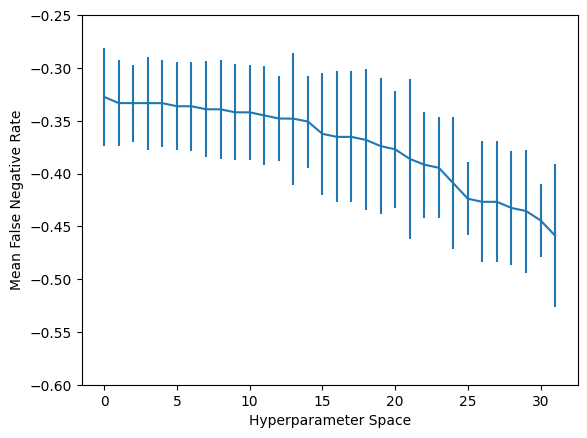

In [22]:
results["mean_test_score"].plot(
    yerr=results["std_test_score"],
    xlabel="Hyperparameter Space",
    ylabel="Mean False Negative Rate",
    ylim=(-0.6, -0.25),
)

plt.show()

#### 2nd Approach

* FNR with the predictions as probabilities.

In [23]:
y_proba = pipe.predict_proba(X_validation)[:, 1]
y_proba[:3]

array([0.3 , 0.  , 0.15])

In [24]:
y_train.value_counts(normalize=True), y_train.value_counts(normalize=True).values[1]

(0    0.610955
 1    0.389045
 Name: Survived, dtype: float64,
 0.3890449438202247)

In [25]:
def calculate_FNR_proba(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """This takes the predictions as probabilities and
    returns the False Negative Rate.
    i.e FNR = (FN) / (FN + TP)
    """
    THRESH = 0.39
    y_pred = np.where(y_pred > THRESH, 1, 0)
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=[0, 1]).flatten()
    FNR = np.divide(FN, np.add(FN, TP))
    return FNR


# Create custom scorer
FNR_score_proba = make_scorer(
    score_func=calculate_FNR_proba,
    greater_is_better=False,
    needs_proba=True,  # requires probability
)

In [26]:
# Grid Search
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

# Hyperparameter space
rf_param_grid = dict(
    n_estimators=[10, 20, 50, 100, 200, 500, 1000, 2000],
    max_depth=[1, 2, 3, 4],
)

# Search
clf = GridSearchCV(
    rf_model,
    rf_param_grid,
    scoring=FNR_score_proba,
    cv=5,
    verbose=0,
    n_jobs=-1,
)

search_grid = clf.fit(X, y)

# Best hyperparameters
search_grid.best_params_

{'max_depth': 4, 'n_estimators': 10}

In [27]:
imp_vars = ["params", "mean_test_score", "std_test_score"]
results = pd.DataFrame(search_grid.cv_results_)[imp_vars]

# Sort the mean_test_scores in descending order and reset the index.
results.sort_values(by="mean_test_score", ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)

results.head()

,params,mean_test_score,std_test_score
0,"{'max_depth': 4, 'n_estimators': 10}",-0.234015,0.048639
1,"{'max_depth': 4, 'n_estimators': 50}",-0.254518,0.072792
2,"{'max_depth': 4, 'n_estimators': 20}",-0.254604,0.071829
3,"{'max_depth': 4, 'n_estimators': 1000}",-0.257417,0.063867
4,"{'max_depth': 3, 'n_estimators': 2000}",-0.257417,0.067699


### Comment

* Using the probability improved the performance. i.e from 0.33 to 0.23 (absolute value)
* Lower is better!
* A model with **FNR** of (0.234 +- 0.05) means that the **FNR** of the test/unseen data should be between `0.184` and `0.284`.

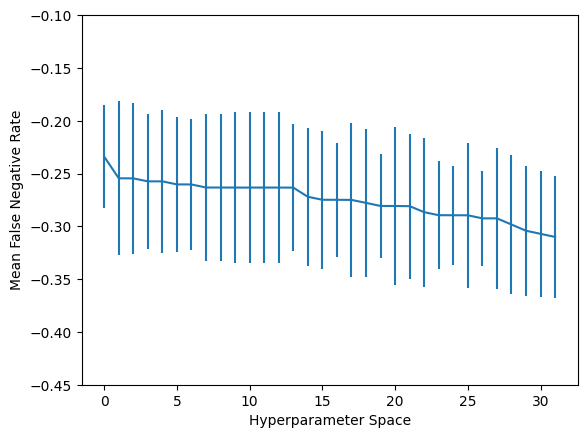

In [28]:
results["mean_test_score"].plot(
    yerr=results["std_test_score"],
    xlabel="Hyperparameter Space",
    ylabel="Mean False Negative Rate",
    ylim=(-0.45, -0.1),
)

plt.show()

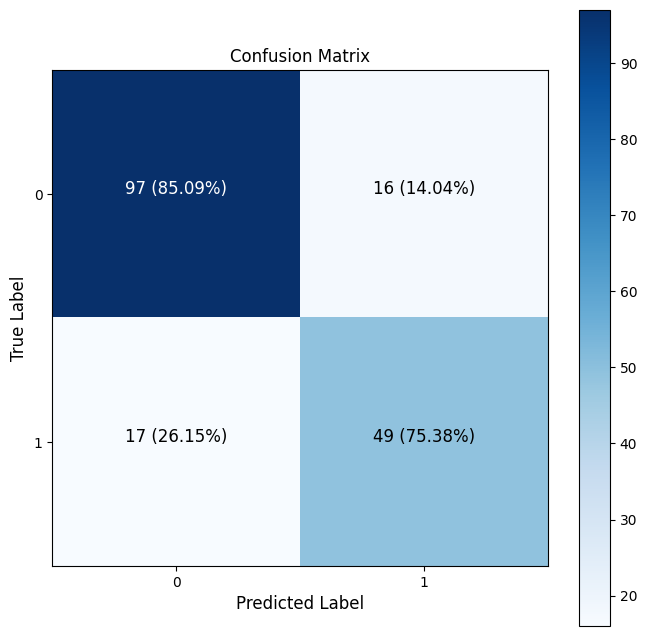

In [29]:
# Using class labels
plot_confusion_matrix(y_true=y_validation, y_pred=y_pred, figsize=(8, 8))

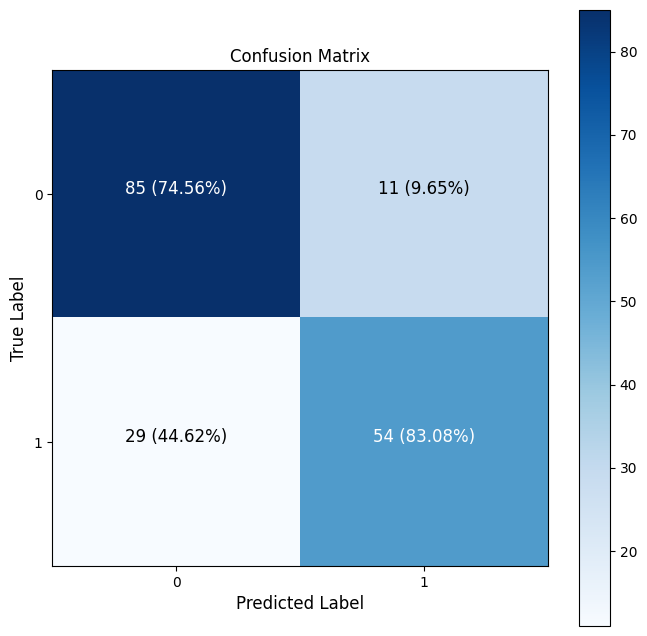

In [30]:
# Using the probabilities
# Convert to class labels
THRESH = 0.39
y_pred_con = np.where(y_proba > THRESH, 1, 0)
plot_confusion_matrix(y_true=y_validation, y_pred=y_pred_con, figsize=(8, 8))

#### Comment

* Reducing the threshold from 0.5 (default) to 0.39 reduced the **FNR** (lower is better!) and improved the **True Positive**.
* The caveat is that the percentage of the **True Negative** dropped!.

In [31]:
roc_auc_score(y_true=y_validation, y_score=y_proba)

0.8628879892037787

### Optimize A Built-in Metric

* The list of sci-kit learn metrics can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules).
* e.g. roc_auc

In [32]:
# Grid Search
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

# Hyperparameter space
rf_param_grid = dict(
    n_estimators=[10, 20, 50, 100, 200, 500, 1000, 2000],
    max_depth=[1, 2, 3, 4],
)

# Search
clf = GridSearchCV(
    rf_model,
    rf_param_grid,
    scoring="roc_auc",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

search_grid = clf.fit(X, y)

# Best hyperparameters
search_grid.best_params_

{'max_depth': 4, 'n_estimators': 50}

In [33]:
imp_vars = ["params", "mean_test_score", "std_test_score"]
results = pd.DataFrame(search_grid.cv_results_)[imp_vars]

# Sort the mean_test_scores in descending order and reset the index.
results.sort_values(by="mean_test_score", ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)

results.head()

,params,mean_test_score,std_test_score
0,"{'max_depth': 4, 'n_estimators': 50}",0.867323,0.019381
1,"{'max_depth': 4, 'n_estimators': 20}",0.866744,0.019707
2,"{'max_depth': 4, 'n_estimators': 100}",0.865432,0.019475
3,"{'max_depth': 4, 'n_estimators': 10}",0.865127,0.017381
4,"{'max_depth': 4, 'n_estimators': 200}",0.864045,0.021070


#### Comment

* A model with **ROC_AUC** of (0.867 +- 0.019) means that the **ROC_AUC** of the test/unseen data should be between `0.848` and `0.886`.

In [34]:
(0.867 - 0.019), (0.867 + 0.019)

(0.848, 0.886)

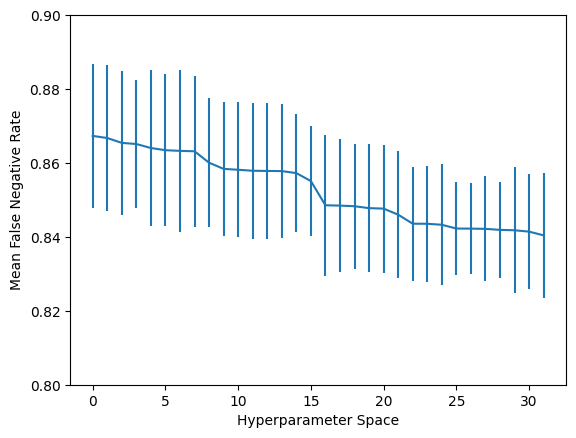

In [35]:
results["mean_test_score"].plot(
    yerr=results["std_test_score"],
    xlabel="Hyperparameter Space",
    ylabel="Mean False Negative Rate",
    ylim=(0.80, 0.90),
)

plt.show()